# Hello California Housing Prices Regressor

End to end Regressor model for California Housing Prices dataset utilizing scikit-learn

In [15]:
# Prerequisites
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
np.set_printoptions(precision=3, suppress=True)

Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Numpy Version:  2.2.2
Pandas Version:  2.2.3


### Fetch and load the dataset

In [1]:
# Prerequisites
from pathlib import Path
import urllib.request
import tarfile

In [4]:
def fetch_housing_dataset():
    tarball_path = Path("datasets/housing.tgz")
    # If file does not exist, fetch it from the net
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_data_file:
            housing_data_file.extractall(path="datasets")

    return pd.read_csv(Path("datasets/housing/housing.csv"))
    

df_housing_raw = fetch_housing_dataset()
df_housing_raw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Exploratory Data Analysis

In [5]:
df_housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


All numberical features, except ocean_proximity.  Examine the values and distribution of Ocean_proximity

In [6]:
df_housing_raw["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
df_housing_raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Visualize Histogram

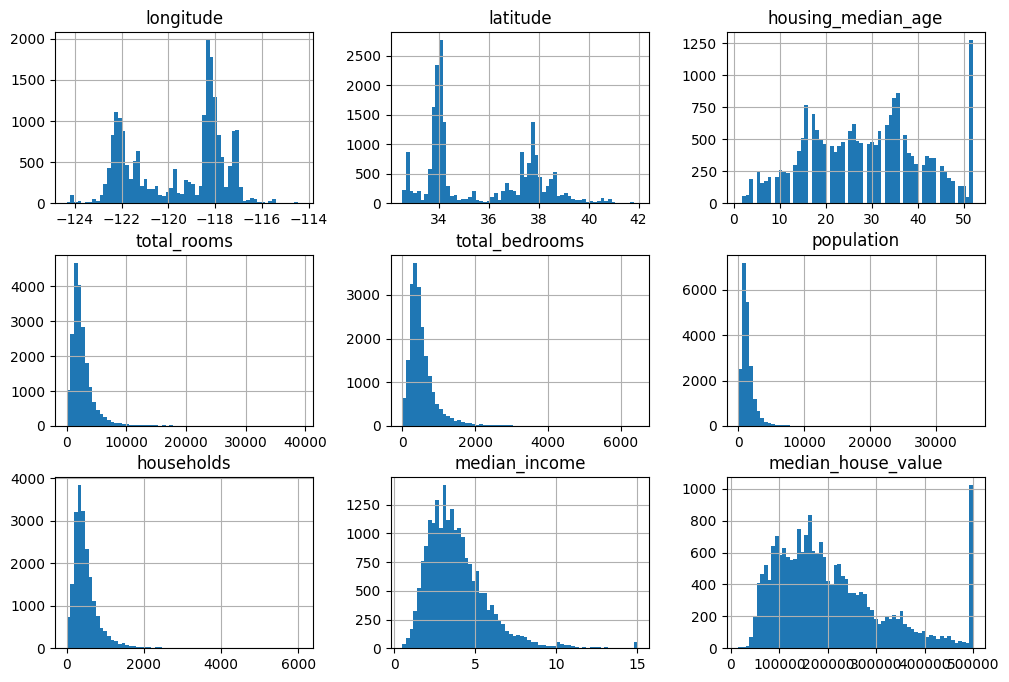

In [16]:
df_housing_raw.hist(bins=64, figsize=(12,8))
plt.show()

### Split into Train and Test sets

Random Split

In [11]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_housing_raw, train_size=0.8, random_state=42)

print(f"Training set size: {df_train.shape[0]}, Test set size: {df_test.shape[0]}")

Training set size: 16512, Test set size: 4128


Ensure that median_income categories get proper representation in the test set

In [13]:
# Split median_income into categories:
df_housing_raw["income_cat"] = pd.cut(df_housing_raw["median_income"],
                                      bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                      labels=[1,2,3,4,5])

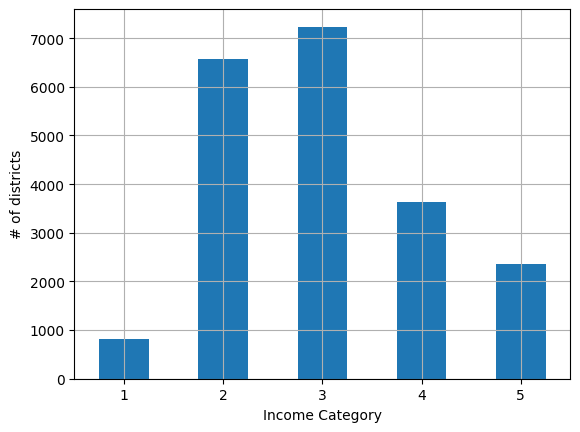

In [17]:
# Visualize the categories
df_housing_raw["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("# of districts")
plt.show()

Perform a Stratified Shuffle Split

In [18]:
df_train_strat, df_test_strat = train_test_split(df_housing_raw, train_size=0.8, 
                                                 stratify=df_housing_raw["income_cat"],
                                                 random_state=42)

print(f"Stratified Training set size: {df_train_strat.shape[0]}, Test set size: {df_test_strat.shape[0]}")

Stratified Training set size: 16512, Test set size: 4128


In [20]:
# Drop income_cat column, no longer needed

for df in (df_train_strat, df_test_strat):
    df.drop("income_cat", axis=1, inplace=True)